In [2]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import LeaveOneOut, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc


In [6]:
df = pd.read_csv("../data/processed/datasets/oa_averages_closed_zed.csv")

In [38]:
df.head().T

,0,1,2,3,4
low stability,0.000000,0.000000,0.000000,0.000000,0.000000
AP MAD,0.477583,0.678276,0.416209,0.523784,0.894796
AP Max abs dev,1.915137,2.495103,1.494899,1.807057,2.814422
AP MedAD,0.400698,0.575909,0.340654,0.439825,0.770389
AP RMS,0.552762,0.718920,0.242351,0.547064,0.720889
AP Range,3.486096,4.335525,2.642785,3.076013,4.881227
AP STD,0.611302,0.850807,0.517066,0.637494,1.107315
AP Variance,0.376368,0.730022,0.275269,0.440424,1.324788
Ellipse area,6.351870,10.981837,2.199867,6.307854,13.272652
ML MAD,0.453337,0.532944,0.189622,0.441627,0.587390


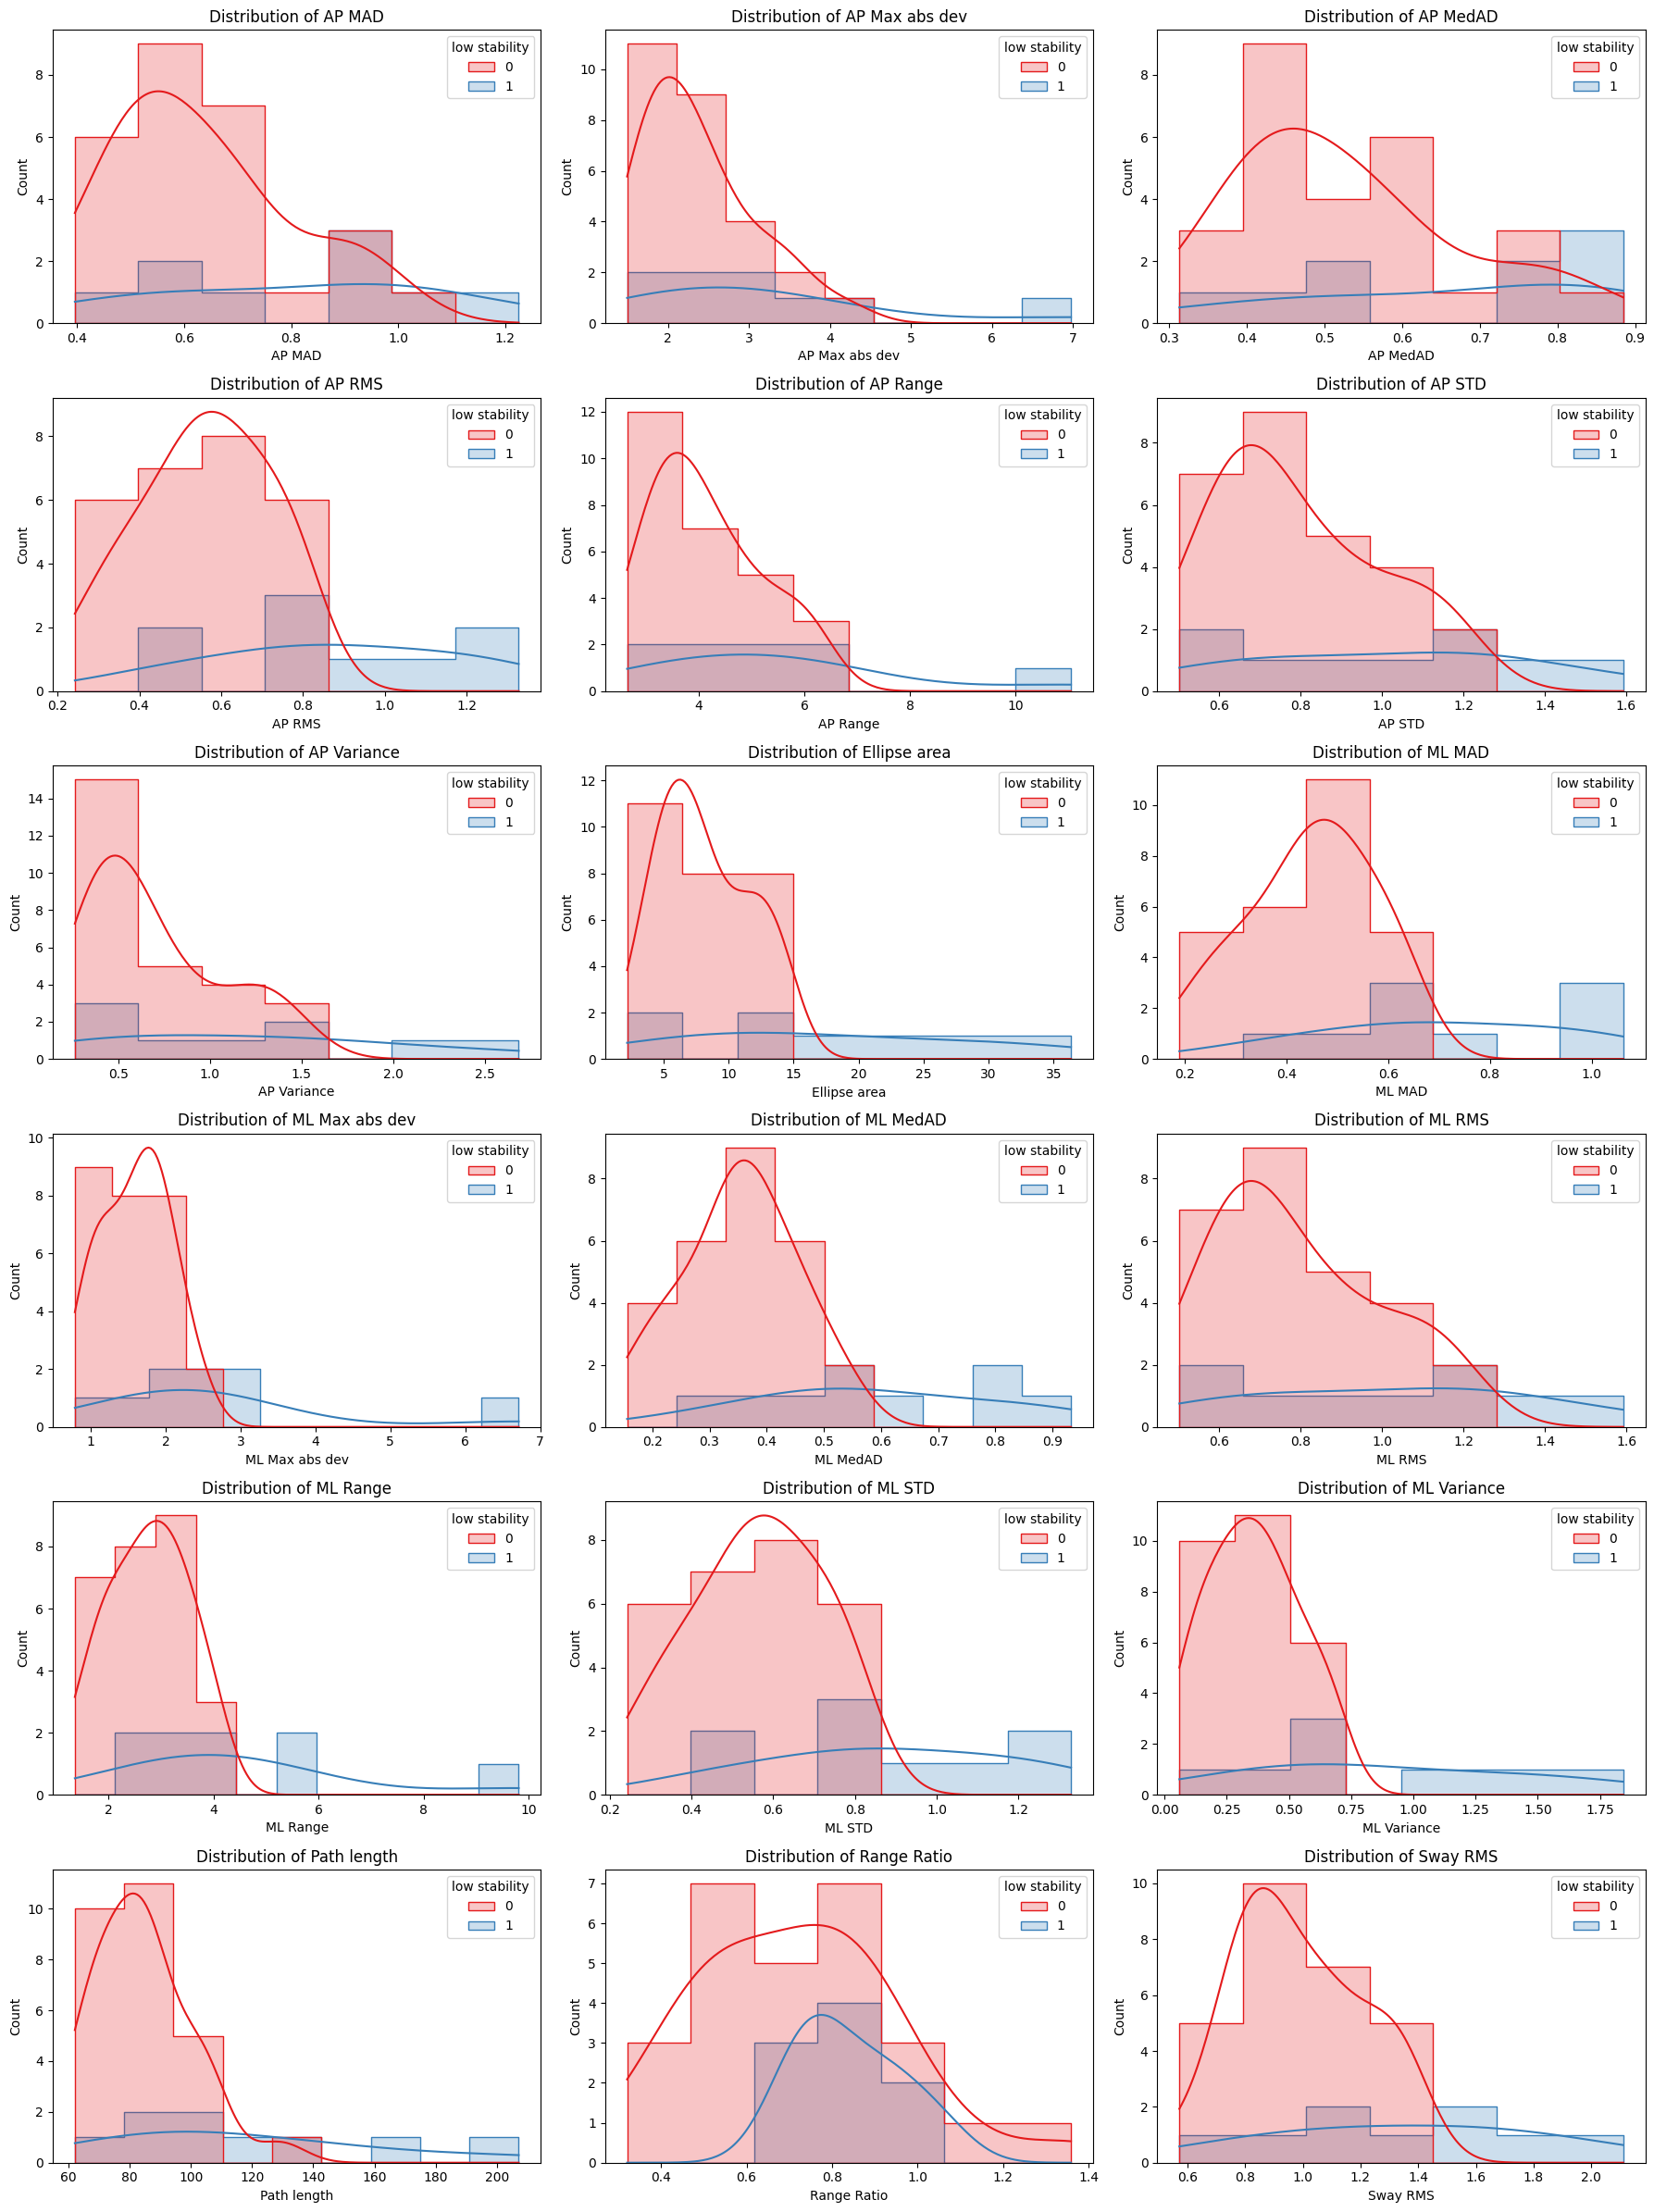

In [8]:
# Exclude target column
feature_columns = df.columns.drop('low stability')

# Set up subplots
n_cols = 3
n_rows = -(-len(feature_columns) // n_cols)  # Ceiling division
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
axes = axes.flatten()

# Plot each feature
for i, feature in enumerate(feature_columns):
    sns.histplot(
        data=df,
        x=feature,
        hue='low stability',
        kde=True,
        element='step',
        palette='Set1',
        ax=axes[i]
    )
    axes[i].set_title(f'Distribution of {feature}')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

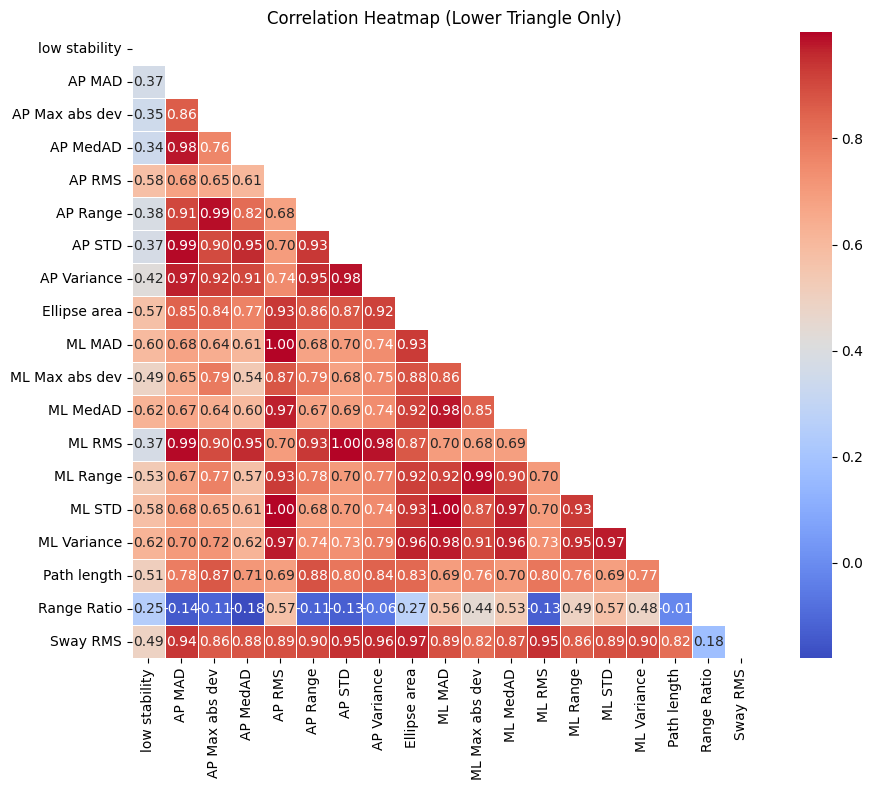

In [9]:
# Select numeric columns
numeric_df = df.select_dtypes(include='number')

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5
)

plt.title("Correlation Heatmap (Lower Triangle Only)")
plt.tight_layout()
plt.show()

## Fitting a model

In [10]:
# Define features and target
X = df.drop(columns=['low stability'])
y = df['low stability']

In [11]:
# Hyperparameter grid for Decision Tree
param_grid = {
    'max_depth': [2, 3, 4, 5],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 4],
    'criterion': ['gini', 'entropy']
}

In [12]:
# Initialize Leave-One-Out CV
loo = LeaveOneOut()

# Store results
y_true = []
y_pred = []
y_proba = []

# Perform LOOCV
for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Perform hyperparameter tuning within the training set
    grid = GridSearchCV(
        DecisionTreeClassifier(random_state=42),
        param_grid,
        cv=3,
        scoring='f1',
        n_jobs=-1
    )
    grid.fit(X_train, y_train)

    # Best model prediction
    best_model = grid.best_estimator_
    prediction = best_model.predict(X_test)
    probability = best_model.predict_proba(X_test)[:, 1]

    # Store results
    y_true.append(y_test.values[0])
    y_pred.append(prediction[0])
    y_proba.append(probability[0])

In [34]:
# Create a DataFrame
results_df = pd.DataFrame({
    'y_true': y_true,
    'y_proba': y_proba
})

# Display the DataFrame
#results_df

In [35]:
results_df['y_proba'].value_counts().sort_index()

y_proba
0.000000     3
0.037037     1
0.041667     1
0.043478    21
0.068966     1
0.333333     1
0.400000     3
1.000000     5
Name: count, dtype: int64

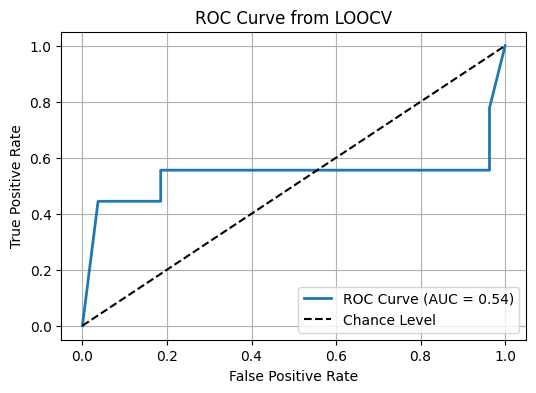

Threshold: inf, TPR: 0.000, FPR: 0.000
Threshold: 1.00000, TPR: 0.444, FPR: 0.037
Threshold: 0.40000, TPR: 0.444, FPR: 0.148
Threshold: 0.33333, TPR: 0.444, FPR: 0.185
Threshold: 0.06897, TPR: 0.556, FPR: 0.185
Threshold: 0.04348, TPR: 0.556, FPR: 0.963
Threshold: 0.03704, TPR: 0.778, FPR: 0.963
Threshold: 0.00000, TPR: 1.000, FPR: 1.000


In [15]:
# Compute FPR, TPR and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Chance Level')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve from LOOCV')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

for i in range(len(thresholds)):
    print(f"Threshold: {thresholds[i]:.5f}, TPR: {tpr[i]:.3f}, FPR: {fpr[i]:.3f}")



In [16]:
print(grid.best_params_)

{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2}


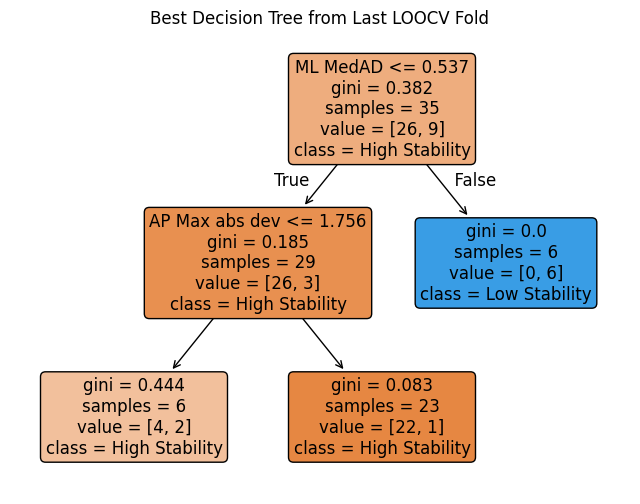

In [17]:
plt.figure(figsize=(8, 6))
plot_tree(
    best_model,
    feature_names=X.columns,
    class_names=["High Stability", "Low Stability"],  # adjust if needed
    filled=True,
    rounded=True,
    fontsize=12
)
plt.title("Best Decision Tree from Last LOOCV Fold")
plt.show()

In [18]:
print("LOOCV Evaluation Metrics (with inner tuning):")
print("Accuracy: ", accuracy_score(y_true, y_pred))
print("Precision: ", precision_score(y_true, y_pred, zero_division=0))
print("Recall: ", recall_score(y_true, y_pred, zero_division=0))
print("F1 Score: ", f1_score(y_true, y_pred, zero_division=0))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

LOOCV Evaluation Metrics (with inner tuning):
Accuracy:  0.8333333333333334
Precision:  0.8
Recall:  0.4444444444444444
F1 Score:  0.5714285714285714
Confusion Matrix:
[[26  1]
 [ 5  4]]


In [61]:
threshold = 0.999
y_pred_custom = [(i >= threshold).astype(int) for i in y_proba]

print("Accuracy: ", accuracy_score(y_true, y_pred_custom))
print("Precision: ", precision_score(y_true, y_pred_custom, zero_division=0))
print("Recall: ", recall_score(y_true, y_pred_custom, zero_division=0))
print("F1 Score: ", f1_score(y_true, y_pred_custom, zero_division=0))


Accuracy:  0.8333333333333334
Precision:  0.8
Recall:  0.4444444444444444
F1 Score:  0.5714285714285714


In [64]:
sns.heatmap(confusion_matrix(y_true, y_pred_custom))


KeyError: "'red' is not a known colormap name"